## A Deep Learning approach to detect deception using Audio Features

In [8]:
import sys
sys.path.append('/home/adrikamukherjee/venv/lib/python3.6/site-packages')

In [9]:
import os, sys, glob, csv, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf, IPython.display as ipd, keras
from sklearn import model_selection, preprocessing
import sklearn
from os import walk, path
from keras import models, layers, optimizers, preprocessing as KRSpreps, utils as KRSutils
#from tslearn import preprocessing as TSpreps, utils as TSutils

### "plot_acc_loss" function plots the validation and training accuracy && validation and training loss

In [10]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

### Preparation of data before processing it

"direc" contains the path of frame wise Audio Features per video extracted using opensmile

Remove unnecesary columns

Seperate data and labels

In [12]:
direc = "/home/adrikamukherjee/csv_frame_wise_fulldata"

In [13]:
df_list, label_list = [], []
for filename in glob.glob(os.path.join(direc, '*.csv')):
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)

### Plot distribution of number of frames from each Audio File

count     8722.000000
mean      1295.318505
std       1043.412818
min         99.000000
25%        699.000000
50%       1000.000000
75%       1600.000000
max      24400.000000
dtype: float64
[300.0, 400.0, 500.0, 599.0, 699.0, 700.0, 800.0, 899.0, 980.0500000000025, 1000.0, 1100.0, 1200.0, 1300.0, 1499.0, 1600.0, 1799.0, 2000.0, 2400.0, 3100.0]


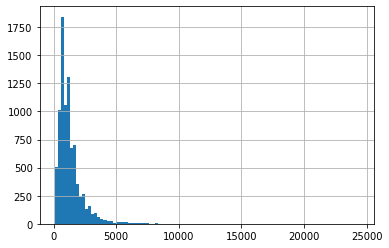

In [14]:
# This is just an analysis of number of rows per audio
### Find Min Max Mean number of frames
len_sequences = []
for one_seq in df_list:
    len_sequences.append(len(one_seq))
len_sequences = pd.Series(len_sequences)
print(len_sequences.describe())
print([val for val in [len_sequences.quantile(q = qtl) for qtl in np.arange(0.05, 1, 0.05)]])
len_sequences.hist(bins = 100)

### Upsample Data using linear method

In [15]:
import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

Timedelta('4 days 13:48:31.069418')

In [16]:
df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

### Find those data which could not be sampled to 1600 frames && Remove them

In [18]:
for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)

(979, 26) 2404
(979, 26) 2467


In [21]:
df_list_interpolated.pop(2466)
label_list.pop(2466)

'Truthful'

### Check if all data is consistent and contains 1600 frames

In [22]:
for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)

### Scale upsampled data

In [ ]:
df_list_audio_interpolated_scaled=[]

for df_individualfile_audio in df_list_interpolated:
    X_d = df_individualfile_audio
    temp = X_d.values 
    st_scaler = sklearn.preprocessing.StandardScaler()
    temp_scaled = st_scaler.fit_transform(temp)
    df_individualfile_audio=pd.DataFrame(temp_scaled)
    feature_list=df_individualfile_audio.columns.tolist()
    df_list_audio_interpolated_scaled.append(df_individualfile_audio)

### Convert data to numpy array && Reshape it

In [23]:
data_X = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 1600, 26)
data_X.shape

(8720, 1600, 26)

### Encode lables

In [24]:
data_y = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)

### "get_seq_model" is the Initial Model

In [25]:
def get_seq_model():
    model = models.Sequential()
    #model.add(layers.LSTM(units=64, recurrent_dropout=0.35, return_sequences=True, input_shape=(2048, 26)))
    #model.add(layers.LSTM(units=64, recurrent_dropout=0.35))
    model.add(layers.Flatten(input_shape=(1600, 26)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001, decay=0.00001), metrics=['accuracy'])
    return model

### "get_seq_model1" is the Final Model Structure, with reduced complexity and l2 Regularization

In [36]:
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
def get_seq_model1():
    #opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt=SGD(lr=0.0001, momentum=0.9)
    model = models.Sequential()
    model.add(layers.LSTM(units=64, recurrent_dropout=0.35, return_sequences=True, input_shape=(1600, 26)))
    #model.add(layers.LSTM(units=64, recurrent_dropout=0.35))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [27]:
data_y=data_y.to_numpy()
type(data_y)

numpy.ndarray

### Split Train and Test data

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.1, random_state=1)
X_train.shape


(7848, 1600, 26)

### Early Stopping used && save the best model

In [29]:
import tensorflow

Train on 7063 samples, validate on 785 samples
Epoch 1/200
7063/7063 [==============================] - 281s 40ms/step - loss: 0.8854 - acc: 0.5605 - val_loss: 0.8841 - val_acc: 0.5682

Epoch 00001: val_acc improved from -inf to 0.56815, saving model to best_model.h5
Epoch 2/200
7063/7063 [==============================] - 279s 39ms/step - loss: 0.8673 - acc: 0.5904 - val_loss: 0.8825 - val_acc: 0.5732

Epoch 00002: val_acc improved from 0.56815 to 0.57325, saving model to best_model.h5
Epoch 3/200
7063/7063 [==============================] - 278s 39ms/step - loss: 0.8604 - acc: 0.5988 - val_loss: 0.8808 - val_acc: 0.5771

Epoch 00003: val_acc improved from 0.57325 to 0.57707, saving model to best_model.h5
Epoch 4/200
7063/7063 [==============================] - 278s 39ms/step - loss: 0.8516 - acc: 0.6116 - val_loss: 0.8791 - val_acc: 0.5720

Epoch 00004: val_acc did not improve from 0.57707
Epoch 5/200
7063/7063 [==============================] - 278s 39ms/step - loss: 0.8525 - acc: 0

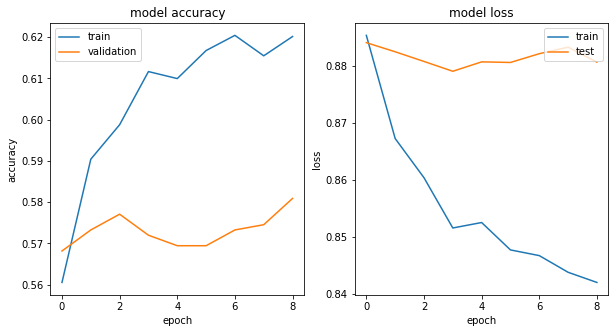

<Figure size 432x288 with 0 Axes>

In [37]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model
model = get_seq_model1()
history = model.fit(X_train, y_train, batch_size=60, validation_split=0.1, epochs=200, verbose=1, callbacks=[es, mc])
plot_acc_loss(history)
plt.savefig('Loss_plot_Audio.png')
plt.show()

### Load the best model and calculate the test loss, test accuracy && Print Confusion Matrix

In [38]:
from keras.models import load_model
model = load_model('best_model.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
y_pred = model.predict(X_test)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.65 else 1), classes = [0, 1])

conf = sklearn.metrics.confusion_matrix
print(conf(y_true, y_pred_det))
target_names = ['0', '1']

872/872 [==============================] - 12s 14ms/step
test loss, test acc: [0.855948015637354, 0.6295871559633027]
[[256  81]
 [386 149]]


### Calculate Metric Scores

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score
# Print f1, precision, and recall scores
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.5 else 1), classes = [0, 1])

prec = precision_score(y_true, y_pred_det , average="macro")
rec = recall_score(y_true, y_pred_det , average="macro")
fsc= f1_score(y_true, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_true, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_true, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_true, y_pred_det)

print('Precision: %f' % prec)
print('Recall: %f' % rec)
print('Fscore: %f' % fsc)
print('Accuracy: %f' % accu)

Cohens kappa: 0.082350
ROC AUC: 0.535048
Precision: 0.618787
Recall: 0.535048
Fscore: 0.478823
Accuracy: 0.629587


In [ ]:
print(sklearn.metrics.classification_report(y_true, y_pred_det,target_names=target_names))
conf_res = conf(y_true, y_pred_det)
print("Precision in Detecting Deception: ", conf_res[1][1]/(conf_res[1][1]+conf_res[0][1]))
print("Recall in Detecting Deception: ", conf_res[1][1]/(conf_res[1][1]+conf_res[1][0]))

### Plot ROC Curve

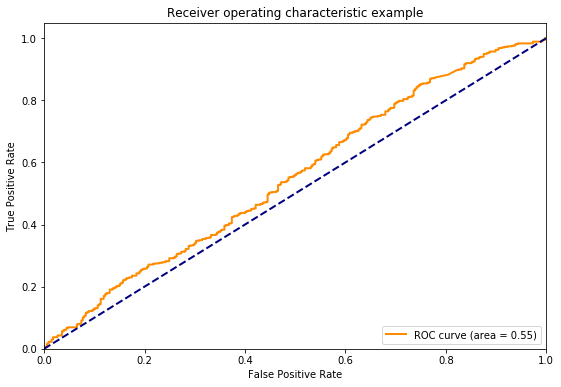

In [40]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
i=0
fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(9, 6))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()